## Import Libraries

In [38]:
# 0. Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


## 1. Data Loading

In [21]:
# 1. Verinin Yüklenmesi
df_train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
df_test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

In [4]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


## 2. Data Analysis

In [6]:
print("Dataset Shape:", df_train.shape)
print("\nData Types:\n", df_train.dtypes)
print("\nMissing Values:\n", df_train.isnull().sum().sum())

Dataset Shape: (27455, 785)

Data Types:
 label       int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 785, dtype: object

Missing Values:
 0


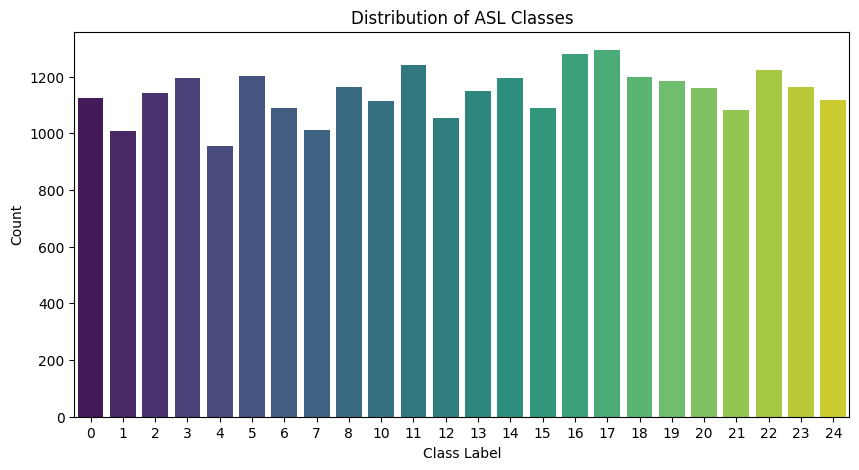

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=df_train, palette='viridis')
plt.title("Distribution of ASL Classes")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

In [8]:
label_map = {i: letter for i, letter in enumerate(string.ascii_uppercase) if letter != 'J'}
df_train['letter'] = df_train['label'].map(label_map)

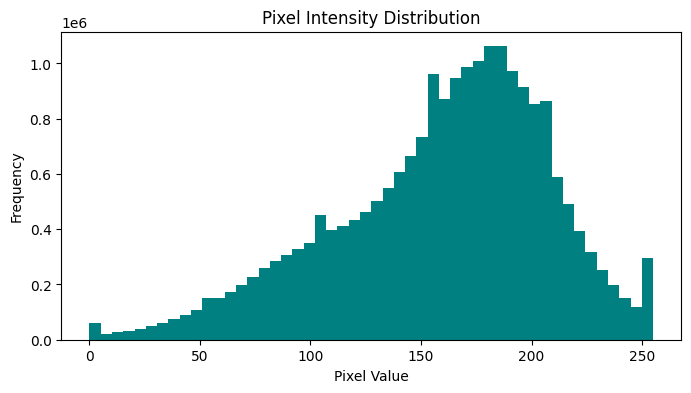

In [10]:
# 6. Pixel intensity histogram (flattened)
plt.figure(figsize=(8, 4))
pixels = X.reshape(-1, 784)
plt.hist(pixels.ravel(), bins=50, color='teal')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


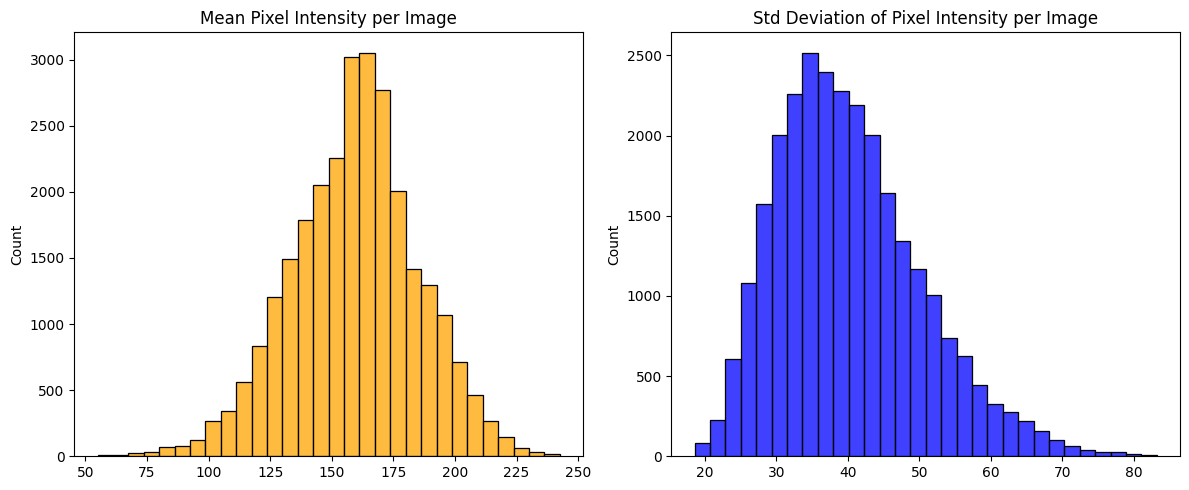

In [11]:
# 7. Mean and std of images
means = pixels.mean(axis=1)
stds = pixels.std(axis=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(means, bins=30, color='orange')
plt.title("Mean Pixel Intensity per Image")

plt.subplot(1, 2, 2)
sns.histplot(stds, bins=30, color='blue')
plt.title("Std Deviation of Pixel Intensity per Image")

plt.tight_layout()
plt.show()

## 3. Preparing Features

In [22]:
# Step 1: Extract labels
y_train = df_train['label']
y_test = df_test['label']

In [23]:
y_train

0         3
1         6
2         2
3         2
4        13
         ..
27450    13
27451    23
27452    18
27453    17
27454    23
Name: label, Length: 27455, dtype: int64

In [24]:
# Step 2: Remove labels from feature set
del df_train['label']
del df_test['label']

In [25]:
# Step 3: Label binarization (One-hot encoding)
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [26]:
# Step 4: Convert feature data to numpy arrays
x_train = df_train.values
x_test = df_test.values

In [27]:
x_train

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       ...,
       [174, 174, 174, ..., 202, 200, 200],
       [177, 181, 184, ...,  64,  87,  93],
       [179, 180, 180, ..., 205, 209, 215]])

In [28]:
# Step 5: Normalize grayscale pixel values to [0, 1]
x_train = x_train / 255
x_test = x_test / 255

In [29]:
x_train

array([[0.41960784, 0.4627451 , 0.49803922, ..., 0.8       , 0.79607843,
        0.79215686],
       [0.60784314, 0.61568627, 0.61176471, ..., 0.40392157, 0.52941176,
        0.58431373],
       [0.73333333, 0.7372549 , 0.7372549 , ..., 0.76470588, 0.76078431,
        0.76470588],
       ...,
       [0.68235294, 0.68235294, 0.68235294, ..., 0.79215686, 0.78431373,
        0.78431373],
       [0.69411765, 0.70980392, 0.72156863, ..., 0.25098039, 0.34117647,
        0.36470588],
       [0.70196078, 0.70588235, 0.70588235, ..., 0.80392157, 0.81960784,
        0.84313725]])

In [32]:
# Step 6: Reshape into (28, 28, 1) for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_train

array([[[[0.41960784],
         [0.4627451 ],
         [0.49803922],
         ...,
         [0.66666667],
         [0.66666667],
         [0.6627451 ]],

        [[0.43529412],
         [0.4745098 ],
         [0.50588235],
         ...,
         [0.67058824],
         [0.67058824],
         [0.66666667]],

        [[0.44313725],
         [0.48235294],
         [0.51372549],
         ...,
         [0.67058824],
         [0.67058824],
         [0.67058824]],

        ...,

        [[0.55686275],
         [0.58823529],
         [0.62352941],
         ...,
         [0.79215686],
         [0.78823529],
         [0.78431373]],

        [[0.55686275],
         [0.59215686],
         [0.62745098],
         ...,
         [0.8       ],
         [0.79607843],
         [0.79215686]],

        [[0.55686275],
         [0.59215686],
         [0.62745098],
         ...,
         [0.8       ],
         [0.79607843],
         [0.79215686]]],


       [[[0.60784314],
         [0.61568627],
         [0.61

/tmp/ipykernel_35/1572084103.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


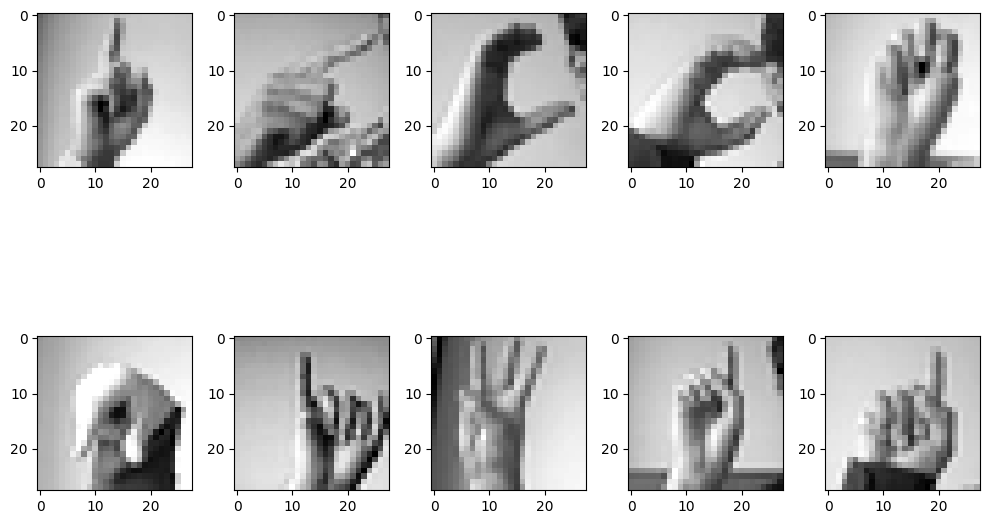

In [33]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28), cmap="gray")
        k += 1
    plt.tight_layout()

## 4. Model Training -  Data Augmentation

In [46]:
# --- Split Validation Set ---
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)
datagen.fit(x_train)

# --- Learning Rate Reduction Callback ---
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

# --- Define CNN Model ---
model = Sequential()
model.add(Conv2D(75, (3,3), strides=1, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(50, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(25, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='softmax'))  # 25 classes: A-Y excluding J

# --- Compile the Model ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train the Model ---
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=30,
    validation_data=(x_val, y_val),
    steps_per_epoch=x_train.shape[0] // 64,
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.4650 - loss: 1.8019 - val_accuracy: 0.0522 - val_loss: 4.8181 - learning_rate: 0.0010
Epoch 2/30
  1/312 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.9062 - loss: 0.3284

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.3284 - val_accuracy: 0.0504 - val_loss: 4.8598 - learning_rate: 0.0010
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.9106 - loss: 0.2662 - val_accuracy: 0.8651 - val_loss: 0.3863 - learning_rate: 0.0010
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.1215 - val_accuracy: 0.8629 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9631 - loss: 0.1183 - val_accuracy: 0.9775 - val_loss: 0.0689 - learning_rate: 0.0010
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.0803 - val_accuracy: 0.9762 - val_loss: 0.0766 - learning_rate: 0.0010
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9714 - loss: 0.0882
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
312/312 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.9714 - loss: 0.0882 - v

## 5. Model Evaluation

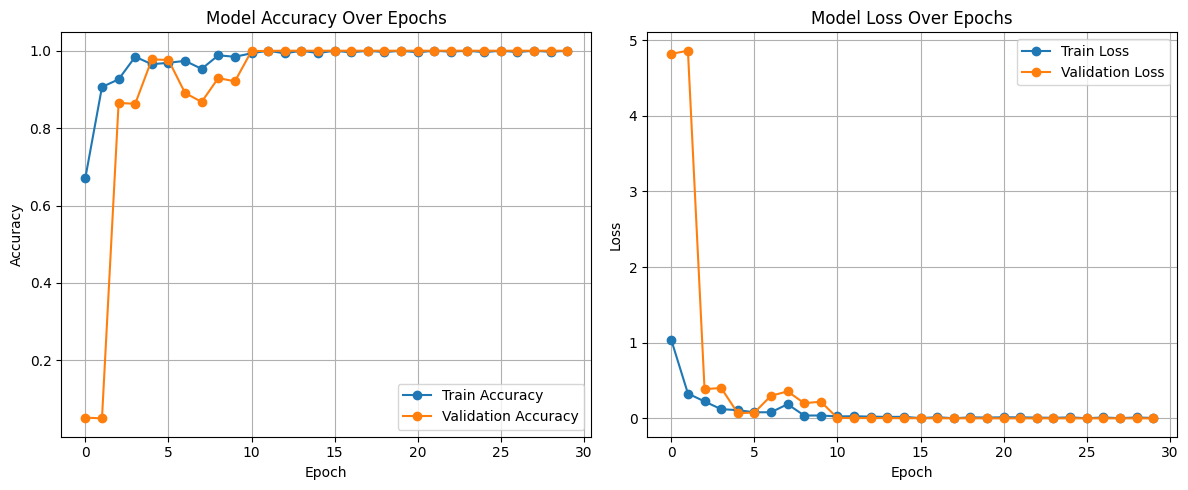

In [47]:
# --- Plot Training & Validation Accuracy/Loss ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Test Performance

In [52]:

# --- Step 2: Evaluate the model on test set ---
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9997 - loss: 0.0033

Test Accuracy: 0.9993
Test Loss: 0.0039
